In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

from datasets import load_dataset

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score

from copy import deepcopy
import missingno as msno
import time

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from tqdm import tqdm

from scipy.stats import shapiro
from scipy import stats
from scipy.stats import kruskal

from LRE import LogisticRegressionEnsemble

In [7]:
import numpy as np
from joblib import Parallel, delayed

class LogisticRegressionEnsemble:
    def __init__(self, num_models = 5, learning_rate = 0.1, iterations = 1000, patience = 5, bias = 1, bag_size=0.8, n_jobs=1, num_features=0.8, random_state=None, polynomial_degree=1, num_nonlinear_features = 1):
        self.learning_rate = learning_rate
        self.num_models = num_models
        self.bias = bias
        self.random_state = random_state
        self.iterations = iterations
        self.patience = patience
        self.bag_size = bag_size
        self.num_features = num_features
        self.polynomial_degree = polynomial_degree
        self.models = []
        self.n_jobs = n_jobs
        self.validation_error = []
        self.num_nonlinear_features = num_nonlinear_features
        self.feature_nonlinear_index = []
    
    def sigmoid(self, z):
        return np.clip(1 / (1 + np.exp(-np.clip(z, -709, 709))), 1e-12, 1 - 1e-12)
    
    def init_weights(self, num_features, iter):
        if self.random_state is not None:
            np.random.seed(self.random_state + iter)
        bounds = 1 / np.sqrt(num_features)
        return np.random.uniform(-bounds, bounds, (num_features))
    
    def generate_polynomial_terms(self, n_features):
        if n_features < 1:
            return []
        
        feature_indices = range(n_features)
        terms = []
        
        for i in feature_indices:
            terms.append([i])
            
        # Add higher degree terms
        for degree in range(2, self.polynomial_degree + 1):
            for i in feature_indices:
                terms.append([i] * degree)
                
            # Interaction terms
            if degree > 1:
                for i in feature_indices:
                    for j in feature_indices[i+1:]:  # Only consider unique combinations
                        term = [i] * (degree - 1) + [j]
                        terms.append(term)
                        if degree > 2:  # Add reverse combination for degree > 2
                            term = [j] * (degree - 1) + [i]
                            terms.append(term)
        
        return terms
    
    def apply_polynomial_features(self, X):
        """Transform input features into polynomial features"""
        n_samples, n_features = X.shape
        terms = self.generate_polynomial_terms(n_features)
        
        # Initialize the transformed features array
        X_transformed = np.ones((n_samples, 1 + len(terms)))  # +1 for bias term
        
        # Calculate each polynomial term
        for i, combo in enumerate(terms):
            term = np.ones(n_samples)
            for feature_idx in combo:
                term *= X[:, feature_idx]
            X_transformed[:, i + 1] = term
            
        return X_transformed
    
    def select_random_features(self, X, iter):
        n_total_features = X.shape[1]
        
        if self.polynomial_degree > 1:
            # Calculate number of features to select based on percentage
            n_features_to_select = max(1, int(self.num_nonlinear_features * n_total_features))
            n_features_to_select = min(n_features_to_select, n_total_features)
            
            if self.random_state is not None:
                np.random.seed(self.random_state + iter)
            
            # Always include the bias term (index 0) and randomly select other features
            selected_indices = np.concatenate([
                [0],  # bias term
                1 + np.random.choice(n_total_features - 1, n_features_to_select - 1, replace=False)
            ])
            
            return np.sort(selected_indices)
        
        return None
    
    def calculate_loss(self, X, y, weights):
        pred = self.sigmoid(X @ weights.T)
        loss = np.sum(((y-pred) * pred * (1-pred)).reshape(-1,1) * X, axis=0)
        return loss
    
    def calculate_error(self, X, y, weights):
        pred = self.sigmoid(X @ weights.T)
        return np.sum((y - pred) ** 2)
    
    def fit_single_model(self, X, y, X_val=None, y_val=None, curr_iteration=-1):
        num_features = X.shape[1]
        weights = self.init_weights(num_features, curr_iteration)
        patience_counter = 0
        best_weights = None
        best_loss = float('inf')
        min_iter = 10
        
        for iter in range(self.iterations):
            loss = self.calculate_loss(X, y, weights)
            weights = weights + self.learning_rate * loss
            
            if X_val is not None and y_val is not None:
                val_error = self.calculate_error(X_val, y_val, weights)
                
                if val_error < best_loss:
                    best_loss = val_error
                    best_weights = weights.copy()
                    patience_counter = 0
                else:
                    patience_counter += 1
                    
                if patience_counter >= self.patience and iter > min_iter:
                    break

            if np.abs(loss).max() < 1e-6 and iter > min_iter:
                break

        return best_weights, best_loss
    
    def fit_single_model_wrapper(self, X, y, iter):
        n_samples, n_features = X.shape
        bag_samples = int(self.bag_size * n_samples)
        feature_subset = int(self.num_features * n_features) if self.num_features else n_features
        
        if self.random_state is not None:
            np.random.seed(self.random_state + iter)
        
        # Bagging: random sample with replacement
        idx = np.random.choice(n_samples, bag_samples, replace=True)
        
        # Create the mask for the bagged instances
        bag_mask = np.zeros(n_samples, dtype=bool)
        bag_mask[idx] = True
        
        # Split the data to create out of bagged instances
        X_bag, y_bag = X[idx], y[idx]
        X_val, y_val = X[~bag_mask], y[~bag_mask]
        
        # Random feature subset
        feature_idx = np.random.choice(n_features, feature_subset, replace=False)
        X_subset = X_bag[:, feature_idx]
        
        # Transform features and select nonlinear terms
        X_transformed = self.apply_polynomial_features(X_subset)
        nonlinear_feature_idx = self.select_random_features(X_transformed, iter)
        
        if nonlinear_feature_idx is not None:
            X_transformed = X_transformed[:, nonlinear_feature_idx]
            if X_val is not None:
                X_val_transformed = self.apply_polynomial_features(X_val[:, feature_idx])
                X_val_transformed = X_val_transformed[:, nonlinear_feature_idx]
        else:
            if X_val is not None:
                X_val_transformed = self.apply_polynomial_features(X_val[:, feature_idx])

        if X_val is not None:
            # Fit model
            weights, best_loss = self.fit_single_model(X_transformed, y_bag, X_val_transformed, y_val)
        else:
            # Fit model
            weights, best_loss = self.fit_single_model(X_transformed, y_bag)
        
        return (feature_idx, weights), best_loss, nonlinear_feature_idx
    
    def fit(self, X, y):
        results = Parallel(n_jobs=self.n_jobs)(
            delayed(self.fit_single_model_wrapper)(X, y, i) 
            for i in range(self.num_models)
        )
        self.models, self.validation_error, self.feature_nonlinear_index = zip(*results)
    
    def predict_proba(self, X):
        probas = []
        for (feature_idx, weights), nonlinear_idx in zip(self.models, self.feature_nonlinear_index):
            X_subset = X[:, feature_idx]
            X_transformed = self.apply_polynomial_features(X_subset)
            if nonlinear_idx is not None:
                X_transformed = X_transformed[:, nonlinear_idx]
            probas.append(self.sigmoid(X_transformed @ weights))
        return np.mean(probas, axis=0)
            
    def predict(self, X):
        return [0 if u < 0.5 else 1 for u in self.predict_proba(X)]
        
    def score(self, X, y):
        return np.mean(self.predict(X) == y)
    
    def f1_score(self, y, y_pred):
        TP = np.sum((y == 1) & (y_pred == 1))
        FP = np.sum((y == 0) & (y_pred == 1))
        FN = np.sum((y == 1) & (y_pred == 0))
        
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        return f1

# The necessary EDA steps that has to be done for the logistic regression ensemble is the following:

- Handle missing values
- Feature Scaling of continuous features
- One hot encode the categorical features
- Encode the target features

# Diabetes dataset

In [5]:
diabetes_df = pd.read_csv('data/diabetes.csv')
diabetes_df

,Age,Gender,BMI,SBP,DBP,FPG,Chol,Tri,HDL,LDL,ALT,BUN,CCR,FFPG,smoking,drinking,family_histroy,Diabetes
0,26,1,20.1,119,81,5.80,4.36,0.86,0.90,2.43,12.0,5.40,63.8,5.40,3.000000,3.000000,0,0
1,40,1,17.7,97,54,4.60,3.70,1.02,1.50,2.04,9.2,3.70,70.3,4.10,1.000000,1.000000,0,0
2,40,2,19.7,85,53,5.30,5.87,1.29,1.75,3.37,10.1,4.10,61.1,4.85,3.000000,3.000000,0,0
3,43,1,23.1,111,71,4.50,4.05,0.74,1.27,2.60,36.5,4.38,73.4,5.30,2.000000,3.000000,0,0
4,36,1,26.5,130,82,5.54,6.69,3.49,0.91,3.64,69.3,3.86,67.5,5.53,3.000000,3.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4298,54,1,23.4,126,75,6.82,5.00,1.50,1.24,2.98,8.0,3.50,77.0,6.70,1.000000,3.000000,0,1
4299,50,2,22.3,115,84,5.32,4.37,2.09,1.37,2.29,21.2,4.40,47.3,6.55,4.860753,4.860753,0,1
4300,67,1,24.6,138,81,4.85,3.89,1.38,1.14,2.17,18.1,4.73,70.6,6.80,3.000000,3.000000,0,1
4301,60,2,29.0,101,60,6.70,5.91,1.29,1.73,2.85,18.9,7.33,50.2,7.00,3.000000,3.000000,0,1


In [8]:
diabetes_df['Diabetes'].value_counts()

Diabetes
0    3000
1    1303
Name: count, dtype: int64

### Check for missing values

In [9]:
diabetes_df.nunique()

Age                70
Gender              2
BMI               275
SBP               111
DBP                75
FPG               361
Chol              486
Tri               478
HDL               188
LDL               384
ALT               680
BUN               576
CCR               700
FFPG              479
smoking             4
drinking            4
family_histroy      2
Diabetes            2
dtype: int64

In [10]:
diabetes_df.isna().sum()

Age               0
Gender            0
BMI               0
SBP               0
DBP               0
FPG               0
Chol              0
Tri               0
HDL               0
LDL               0
ALT               0
BUN               0
CCR               0
FFPG              0
smoking           0
drinking          0
family_histroy    0
Diabetes          0
dtype: int64

### Check the distribution of the classes to each feature

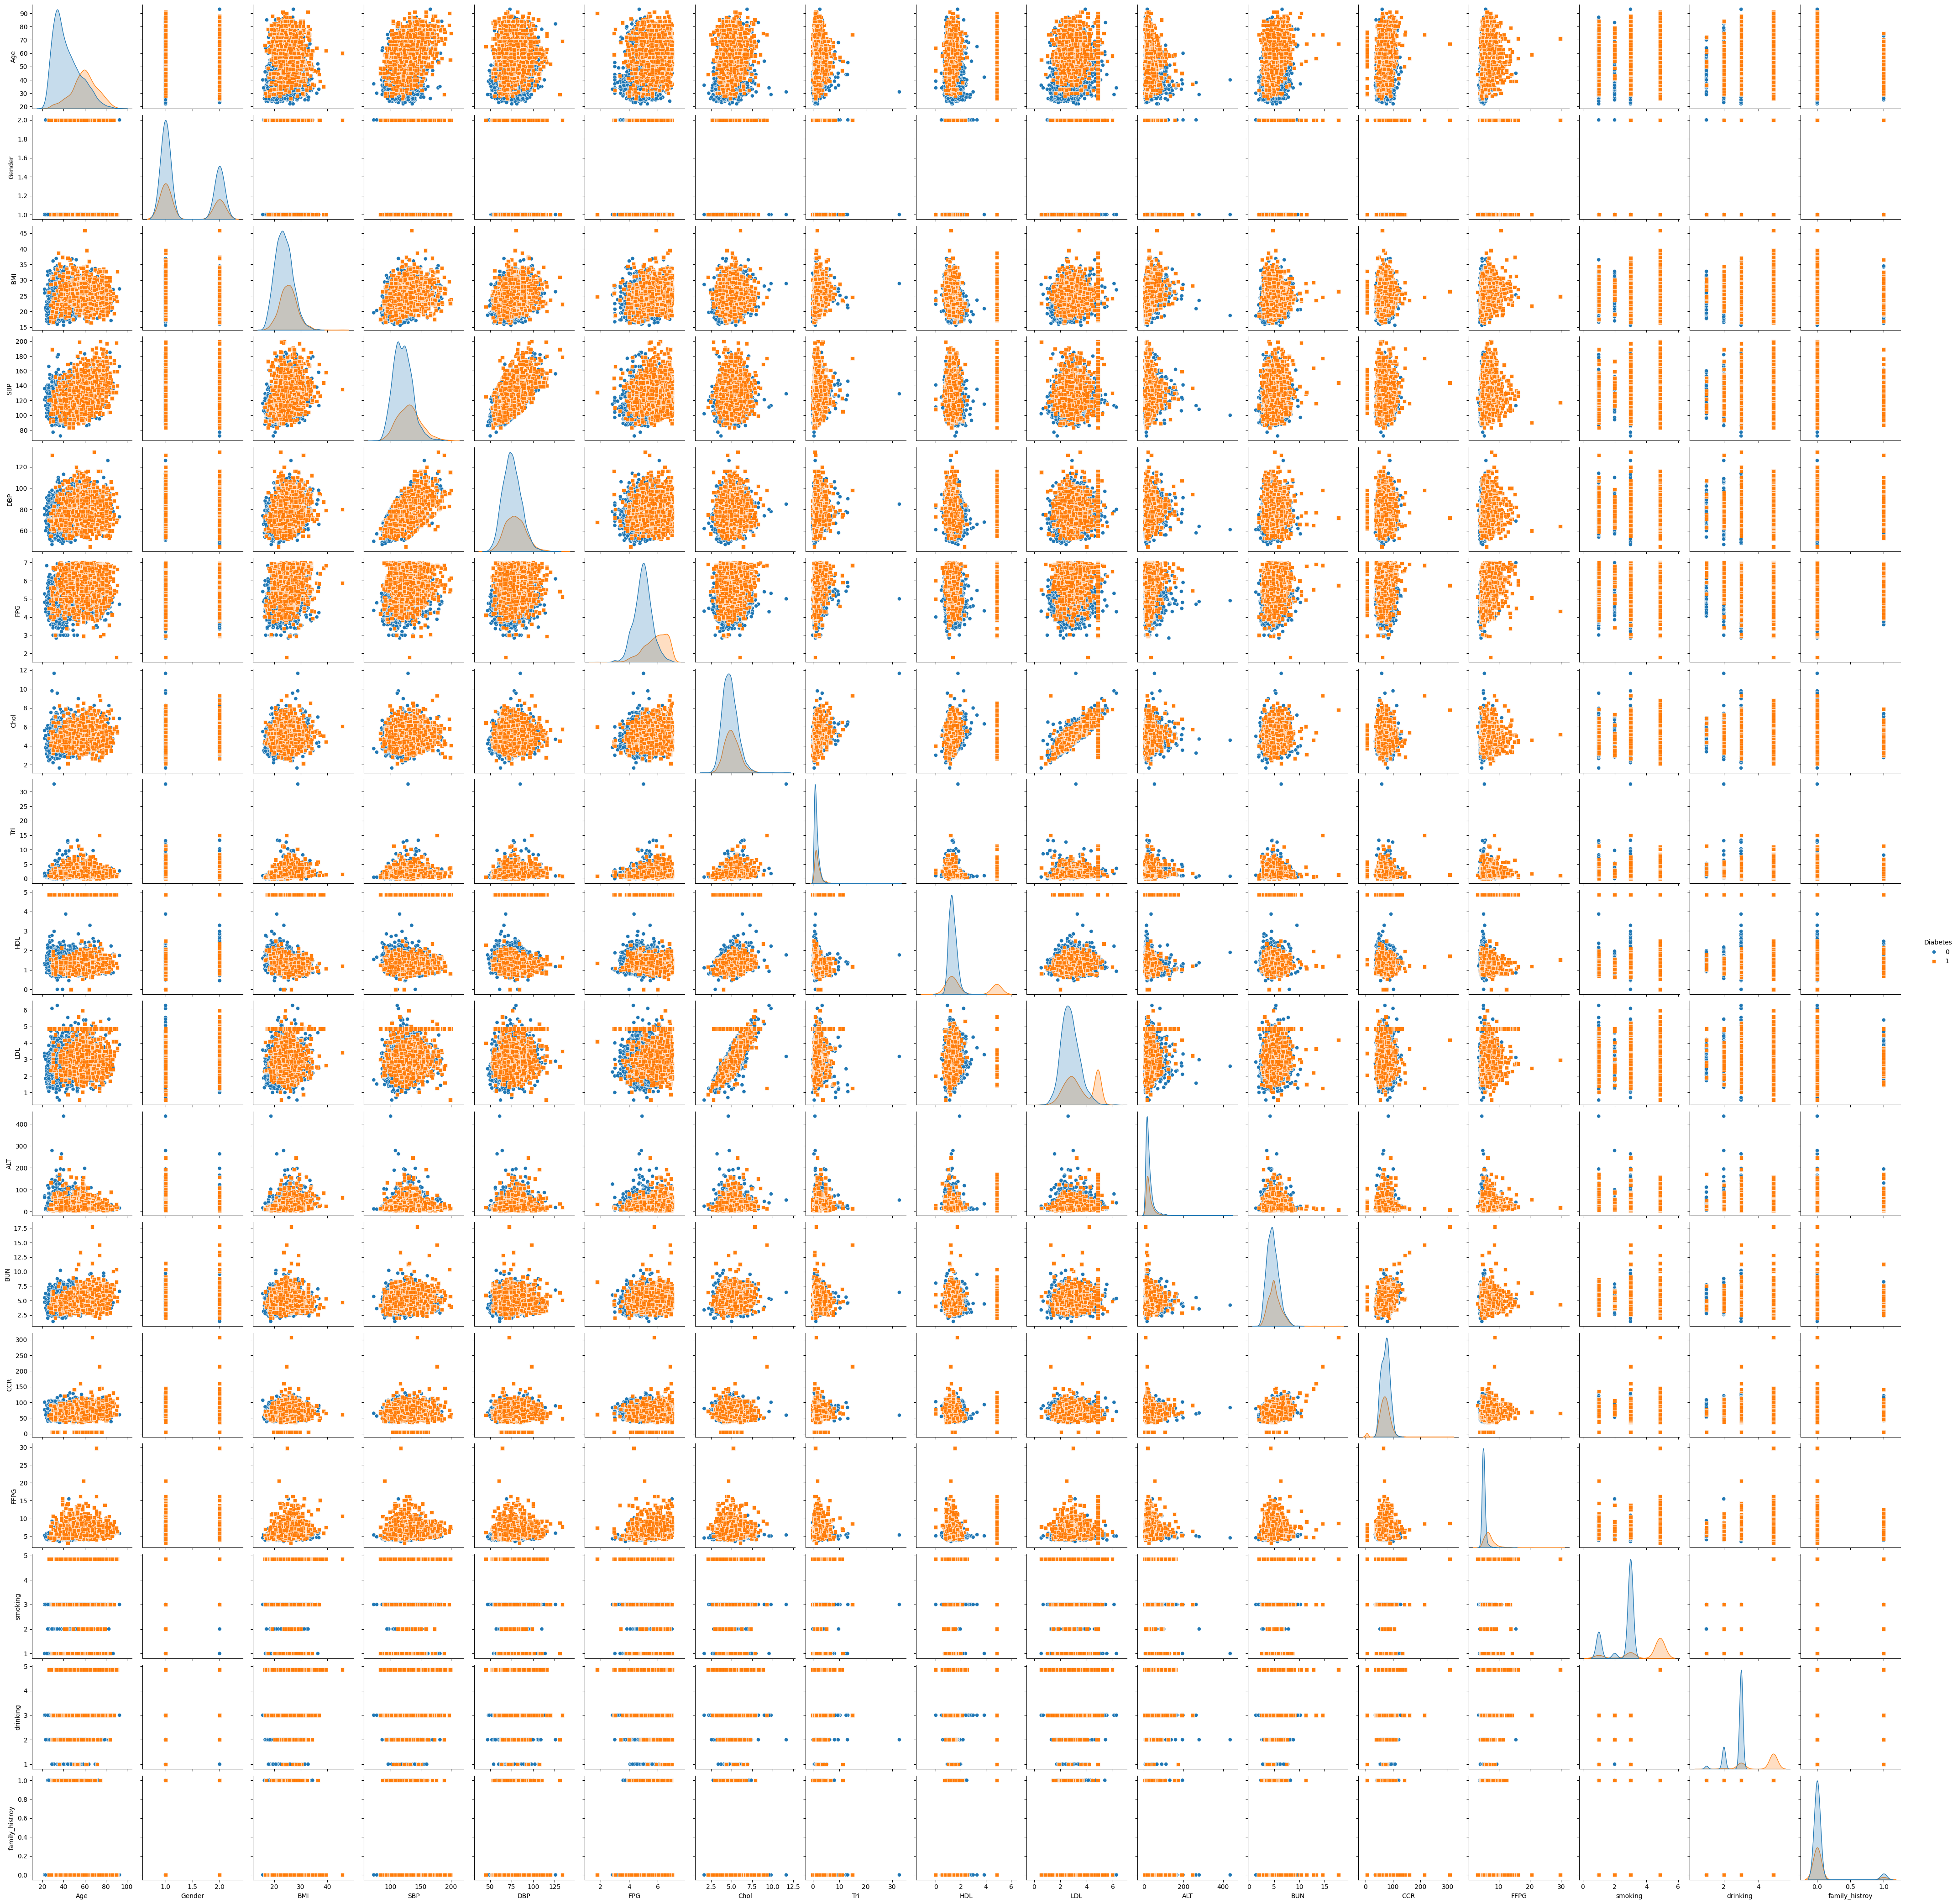

In [10]:
sns.pairplot(diabetes_df, hue='Diabetes', diag_kind='kde', markers=["o", "s"])

### Normalisation of the continuous features (Between [-1,1])

In [11]:
X = diabetes_df.drop("Diabetes", axis=1)
y = diabetes_df['Diabetes']

In [12]:
X

,Age,Gender,BMI,SBP,DBP,FPG,Chol,Tri,HDL,LDL,ALT,BUN,CCR,FFPG,smoking,drinking,family_histroy
0,26,1,20.1,119,81,5.80,4.36,0.86,0.90,2.43,12.0,5.40,63.8,5.40,3.000000,3.000000,0
1,40,1,17.7,97,54,4.60,3.70,1.02,1.50,2.04,9.2,3.70,70.3,4.10,1.000000,1.000000,0
2,40,2,19.7,85,53,5.30,5.87,1.29,1.75,3.37,10.1,4.10,61.1,4.85,3.000000,3.000000,0
3,43,1,23.1,111,71,4.50,4.05,0.74,1.27,2.60,36.5,4.38,73.4,5.30,2.000000,3.000000,0
4,36,1,26.5,130,82,5.54,6.69,3.49,0.91,3.64,69.3,3.86,67.5,5.53,3.000000,3.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4298,54,1,23.4,126,75,6.82,5.00,1.50,1.24,2.98,8.0,3.50,77.0,6.70,1.000000,3.000000,0
4299,50,2,22.3,115,84,5.32,4.37,2.09,1.37,2.29,21.2,4.40,47.3,6.55,4.860753,4.860753,0
4300,67,1,24.6,138,81,4.85,3.89,1.38,1.14,2.17,18.1,4.73,70.6,6.80,3.000000,3.000000,0
4301,60,2,29.0,101,60,6.70,5.91,1.29,1.73,2.85,18.9,7.33,50.2,7.00,3.000000,3.000000,0


In [13]:
X_norm = 2 * ((X - X.min()) / (X.max() - X.min())) - 1
X_norm.describe()

,Age,Gender,BMI,SBP,DBP,FPG,Chol,Tri,HDL,LDL,ALT,BUN,CCR,FFPG,smoking,drinking,family_histroy
count,4303.000000,4303.00000,4303.000000,4303.000000,4303.000000,4303.000000,4303.000000,4303.000000,4303.000000,4303.000000,4303.000000,4303.000000,4303.000000,4303.000000,4303.000000,4303.000000,4303.000000
mean,-0.265210,-0.29677,-0.435502,-0.199697,-0.295271,0.322982,-0.357849,-0.902667,-0.314195,-0.149661,-0.896897,-0.576625,-0.558506,-0.809126,0.039239,0.144821,-0.876830
std,0.413694,0.95506,0.224986,0.273654,0.247282,0.299842,0.185075,0.077206,0.444119,0.311412,0.103219,0.153097,0.112116,0.107515,0.621418,0.486870,0.480856
min,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.633803,-1.00000,-0.596026,-0.390625,-0.460674,0.120921,-0.490000,-0.947304,-0.535051,-0.368237,-0.954598,-0.684404,-0.635008,-0.871698,0.036067,0.036067,-1.000000
50%,-0.323944,-1.00000,-0.443709,-0.218750,-0.303371,0.289827,-0.372000,-0.921569,-0.448645,-0.204188,-0.925874,-0.586544,-0.555574,-0.841509,0.036067,0.036067,-1.000000
75%,0.042254,1.00000,-0.291391,-0.031250,-0.146067,0.504798,-0.244000,-0.881127,-0.337551,0.005236,-0.876998,-0.487462,-0.487394,-0.787170,0.036067,0.036067,-1.000000
max,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
X_norm

,Age,Gender,BMI,SBP,DBP,FPG,Chol,Tri,HDL,LDL,ALT,BUN,CCR,FFPG,smoking,drinking,family_histroy
0,-0.887324,-1.0,-0.701987,-0.265625,-0.191011,0.543186,-0.458,-0.947304,-0.629687,-0.340314,-0.965254,-0.508257,-0.609854,-0.833962,0.036067,0.036067,-1.0
1,-0.492958,-1.0,-0.860927,-0.609375,-0.797753,0.082534,-0.590,-0.937500,-0.382812,-0.476440,-0.978226,-0.716208,-0.566827,-0.932075,-1.000000,-1.000000,-1.0
2,-0.492958,1.0,-0.728477,-0.796875,-0.820225,0.351248,-0.156,-0.920956,-0.279947,-0.012216,-0.974056,-0.667278,-0.627726,-0.875472,0.036067,0.036067,-1.0
3,-0.408451,-1.0,-0.503311,-0.390625,-0.415730,0.044146,-0.520,-0.954657,-0.477447,-0.280977,-0.851749,-0.633028,-0.546307,-0.841509,-0.481966,0.036067,-1.0
4,-0.605634,-1.0,-0.278146,-0.093750,-0.168539,0.443378,0.008,-0.786152,-0.625572,0.082024,-0.699792,-0.696636,-0.585362,-0.824151,0.036067,0.036067,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4298,-0.098592,-1.0,-0.483444,-0.156250,-0.325843,0.934741,-0.330,-0.908088,-0.489791,-0.148342,-0.983785,-0.740673,-0.522477,-0.735849,-1.000000,0.036067,-1.0
4299,-0.211268,1.0,-0.556291,-0.328125,-0.123596,0.358925,-0.456,-0.871936,-0.436301,-0.389180,-0.922631,-0.630581,-0.719075,-0.747170,1.000000,1.000000,-1.0
4300,0.267606,-1.0,-0.403974,0.031250,-0.191011,0.178503,-0.552,-0.915441,-0.530937,-0.431065,-0.936993,-0.590214,-0.564841,-0.728302,0.036067,0.036067,-1.0
4301,0.070423,1.0,-0.112583,-0.546875,-0.662921,0.888676,-0.148,-0.920956,-0.288176,-0.193717,-0.933287,-0.272171,-0.699878,-0.713208,0.036067,0.036067,-1.0


In [15]:
X_final = np.asarray(X_norm)
y_encoded = np.asarray(y)

### There is no categorical features to encode and the target feature is already encoded

In [15]:
from sklearn.model_selection import KFold
import numpy as np
from joblib import Parallel, delayed

from sklearn.model_selection import KFold
import numpy as np
from joblib import Parallel, delayed

def cross_validate_single_fold(model_params, X, y, train_indices, val_indices, test_indices, fold_num):
    X_test, y_test = X[test_indices], y[test_indices]
    X_val, y_val = X[val_indices], y[val_indices]
    X_train = X[train_indices]
    y_train = y[train_indices]

    # Unpack model parameters
    eta, num_epochs, patience = model_params

    # Initialize the model with the current set of hyperparameters
    model = LogisticRegressionEnsemble(num_models=1, learning_rate=eta, iterations=num_epochs, patience=patience, num_features=1)

    model.random_state = fold_num
    weights, loss = model.fit_single_model(model.apply_polynomial_features(X_train), y_train, X_val=model.apply_polynomial_features(X_val), y_val=y_val, curr_iteration=fold_num)
    y_pred = np.asarray([0 if u < 0.5 else 1 for u in model.sigmoid(model.apply_polynomial_features(X_test) @ weights)])
    score = model.f1_score(y_test, y_pred)
    return 1-score

def cross_validate_parallel(model_params, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    folds = list(kf.split(X))

    def get_indices(i):
        test_indices = folds[i][1]
        val_indices = folds[i-1][1]
        train_indices = np.concatenate([folds[j][1] for j in range(len(folds)) if j not in [i, i-1]])
        return train_indices, val_indices, test_indices

    scores = Parallel(n_jobs=5)(
        delayed(cross_validate_single_fold)(
            model_params, X, y, *get_indices(i), i
        ) for i in range(n_splits)
    )

    scores_acc = np.mean(scores)
    scores_std = np.std(scores)
    return (scores_acc + scores_std) / 2

def objective(params):
    print(params)
    return cross_validate_parallel(params, X_final, y_encoded)

# Define the hyperparameter search space
search_space = [
    Real(1e-4, 1e-1, "log-uniform", name='eta'),
    Integer(1000, 30000, name='num_epochs'),
    Integer(5, 10, name='patience'),
]

# Run Bayesian optimization
result = gp_minimize(
    objective,
    search_space,
    n_calls=50,
    n_initial_points=20,
    random_state=42,
    noise=1e-8,
    n_jobs = 1,
    acq_func='EI',  # Expected Improvement acquisition function
    acq_optimizer='auto',
    verbose=True
)

# Print the best hyperparameters found
print("Best hyperparameters found:")
print(f"Learning rate (eta): {result.x[0]}")
print(f"Number of epochs units: {result.x[1]}")
print(f"Patience: {result.x[2]}")

Iteration No: 1 started. Evaluating function at random point.
[0.024526126311336792, 6320, 9]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.6549
Function value obtained: 0.0528
Current minimum: 0.0528
Iteration No: 2 started. Evaluating function at random point.
[0.006173770394704579, 13929, 5]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 9.9928
Function value obtained: 0.0499
Current minimum: 0.0499
Iteration No: 3 started. Evaluating function at random point.
[0.0023864188780056083, 10678, 6]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 8.1165
Function value obtained: 0.0496
Current minimum: 0.0496
Iteration No: 4 started. Evaluating function at random point.
[0.008967376801947965, 2636, 9]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 2.1675
Function value obtained: 0.0496
Current minimum: 0.0496
Iteration No: 5 started. Evaluating function at random point.
[0.06541210527692738, 1023, 10]
Ite

In [19]:
# Define the parameter grid
bag_size_values = [0.4, 0.5, 0.6, 0.7, 0.8]
num_features_values = [0.4, 0.5, 0.6, 0.7, 0.8]
num_models_values = [5, 10, 20, 50, 100]

# Initialize a DataFrame to store results
results = pd.DataFrame(columns=["bag_size", "num_features", "num_models", "fold", "f1_score"])

# Define 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop over each parameter combination
for bag_size in tqdm(bag_size_values):
    for num_features in num_features_values:
        for num_models in num_models_values:
            f1_scores = []

            # Perform cross-validation
            for fold, (train_index, test_index) in enumerate(kf.split(X)):
                X_train, X_test = X_final[train_index], X_final[test_index]
                y_train, y_test = y_encoded[train_index], y_encoded[test_index]
                
                # Create and fit the ensemble model
                model = LogisticRegressionEnsemble(
                    num_models=num_models, bag_size=bag_size, num_features=num_features, n_jobs=-1, learning_rate=0.011214774784159465,
                    patience=9, iterations=18690, random_state=42)
                model.fit(X_train, y_train)
                
                # Predict and evaluate F1 score
                y_pred = model.predict(X_test)
                f1 = f1_score(y_test, y_pred)
                
                # Append results for each fold
                results = pd.concat([results, pd.DataFrame([{
                        "bag_size": bag_size,
                        "num_features": num_features,
                        "num_models": num_models,
                        "fold": fold + 1,
                        "f1_score": f1
                    }])], ignore_index=True)

# Save the results DataFrame to a JSON file
results.to_csv("/kaggle/working/results/diabetes_linear_results.csv", index=False)

100%|██████████| 5/5 [6:40:28<00:00, 4805.61s/it]  


OSError: Cannot save file into a non-existent directory: '/kaggle/working/results'

In [22]:
# Save the results DataFrame to a JSON file
results.to_csv("/kaggle/working/diabetes_linear_results.csv", index=False)

## Non-linear

In [24]:
def cross_validate_single_fold(model_params, X, y, train_indices, val_indices, test_indices, fold_num):
    X_test, y_test = X[test_indices], y[test_indices]
    X_val, y_val = X[val_indices], y[val_indices]
    X_train = X[train_indices]
    y_train = y[train_indices]

    # Unpack model parameters
    eta, num_epochs, patience, num_nonlinear_features, polynomial_degree = model_params

    # Initialize the model with the current set of hyperparameters
    model = LogisticRegressionEnsemble(num_models=1, learning_rate=eta, iterations=num_epochs, patience=patience, polynomial_degree=polynomial_degree,
                                       num_features=1, num_nonlinear_features=num_nonlinear_features)

    model.random_state = fold_num

    X_transform = model.apply_polynomial_features(X_train)
    nonlinear_feature_idx = model.select_random_features(X_transform, fold_num)
    
    weights, loss = model.fit_single_model(X_transform[:, nonlinear_feature_idx], y_train, X_val=model.apply_polynomial_features(X_val)[:, nonlinear_feature_idx], y_val=y_val, curr_iteration=fold_num)
    y_pred = np.asarray([0 if u < 0.5 else 1 for u in model.sigmoid(model.apply_polynomial_features(X_test)[:,nonlinear_feature_idx] @ weights)])
    score = model.f1_score(y_test, y_pred)
    return 1-score

def cross_validate_parallel(model_params, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    folds = list(kf.split(X))

    def get_indices(i):
        test_indices = folds[i][1]
        val_indices = folds[i-1][1]
        train_indices = np.concatenate([folds[j][1] for j in range(len(folds)) if j not in [i, i-1]])
        return train_indices, val_indices, test_indices

    scores = Parallel(n_jobs=5)(
        delayed(cross_validate_single_fold)(
            model_params, X, y, *get_indices(i), i
        ) for i in range(n_splits)
    )

    scores_acc = np.mean(scores)
    scores_std = np.std(scores)
    return (scores_acc + scores_std) / 2

def objective(params):
    print(params)
    return cross_validate_parallel(params, X_final, y_encoded)

# Define the hyperparameter search space
search_space = [
    Real(1e-4, 1e-1, "log-uniform", name='eta'),
    Integer(1000, 30000, name='num_epochs'),
    Integer(5, 10, name='patience'),
    Categorical([0.4, 0.5, 0.6, 0.7, 0.8], name='num_nonlinear_features'),
    Integer(2,3, name='polynomial_degree')
]

# Run Bayesian optimization
result = gp_minimize(
    objective,
    search_space,
    n_calls=50,
    n_initial_points=20,
    random_state=42,
    noise=1e-8,
    n_jobs = 1,
    acq_func='EI',  # Expected Improvement acquisition function
    acq_optimizer='auto',
    verbose=True
)

# Print the best hyperparameters found
print("Best hyperparameters found:")
print(f"Learning rate (eta): {result.x[0]}")
print(f"Number of epochs units: {result.x[1]}")
print(f"Patience: {result.x[2]}")
print(f"Number of nonlinear features: {result.x[3]}")
print(f"Polynomial degree: {result.x[4]}")

Iteration No: 1 started. Evaluating function at random point.
[0.024526126311336792, 2651, 9, 0.6, 2]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.4044
Function value obtained: 0.3172
Current minimum: 0.3172
Iteration No: 2 started. Evaluating function at random point.
[0.00019949166150633933, 5133, 7, 0.4, 3]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 20.9845
Function value obtained: 0.0495
Current minimum: 0.0495
Iteration No: 3 started. Evaluating function at random point.
[0.00014765043713594345, 7498, 10, 0.4, 3]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 30.2887
Function value obtained: 0.0491
Current minimum: 0.0491
Iteration No: 4 started. Evaluating function at random point.
[0.007119418600172993, 6505, 5, 0.4, 3]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 12.4067
Function value obtained: 0.0494
Current minimum: 0.0491
Iteration No: 5 started. Evaluating function at random point

In [16]:
# Define the parameter grid
bag_size_values = [0.4, 0.5, 0.6, 0.7, 0.8]
num_features_values = [0.4, 0.5, 0.6, 0.7, 0.8]
num_models_values = [5, 10, 20, 50, 100]
# Initialize a DataFrame to store results
nl_results = pd.DataFrame(columns=["bag_size", "num_features", "num_models", "fold", "f1_score"])

# Define 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop over each parameter combination
for bag_size in tqdm(bag_size_values):
    for num_features in num_features_values:
        for num_models in num_models_values:
            f1_scores = []

            # Perform cross-validation
            for fold, (train_index, test_index) in enumerate(kf.split(X)):
                X_train, X_test = X_final[train_index], X_final[test_index]
                y_train, y_test = y_encoded[train_index], y_encoded[test_index]
                
                # Create and fit the ensemble model
                model = LogisticRegressionEnsemble(
                    num_models=num_models,
                    bag_size=bag_size,
                    num_features=num_features,
                    n_jobs=6,
                    learning_rate=0.007829353954327989,
                    patience=6,
                    polynomial_degree=3,
                    num_nonlinear_features=0.8,
                    iterations=1000,
                    random_state=42
                )
                model.fit(X_train, y_train)
                
                # Predict and evaluate F1 score
                y_pred = model.predict(X_test)
                f1 = f1_score(y_test, y_pred)
                
                # Append results for each fold
                nl_results = pd.concat([nl_results, pd.DataFrame([{
                        "bag_size": bag_size,
                        "num_features": num_features,
                        "num_models": num_models,
                        "fold": fold + 1,
                        "f1_score": f1
                    }])], ignore_index=True)
# Save the results DataFrame to a JSON file
nl_results.to_csv("/kaggle/working/diabetes_nonlinear_results.csv", index=False)

100%|██████████| 5/5 [1:07:30<00:00, 810.16s/it]


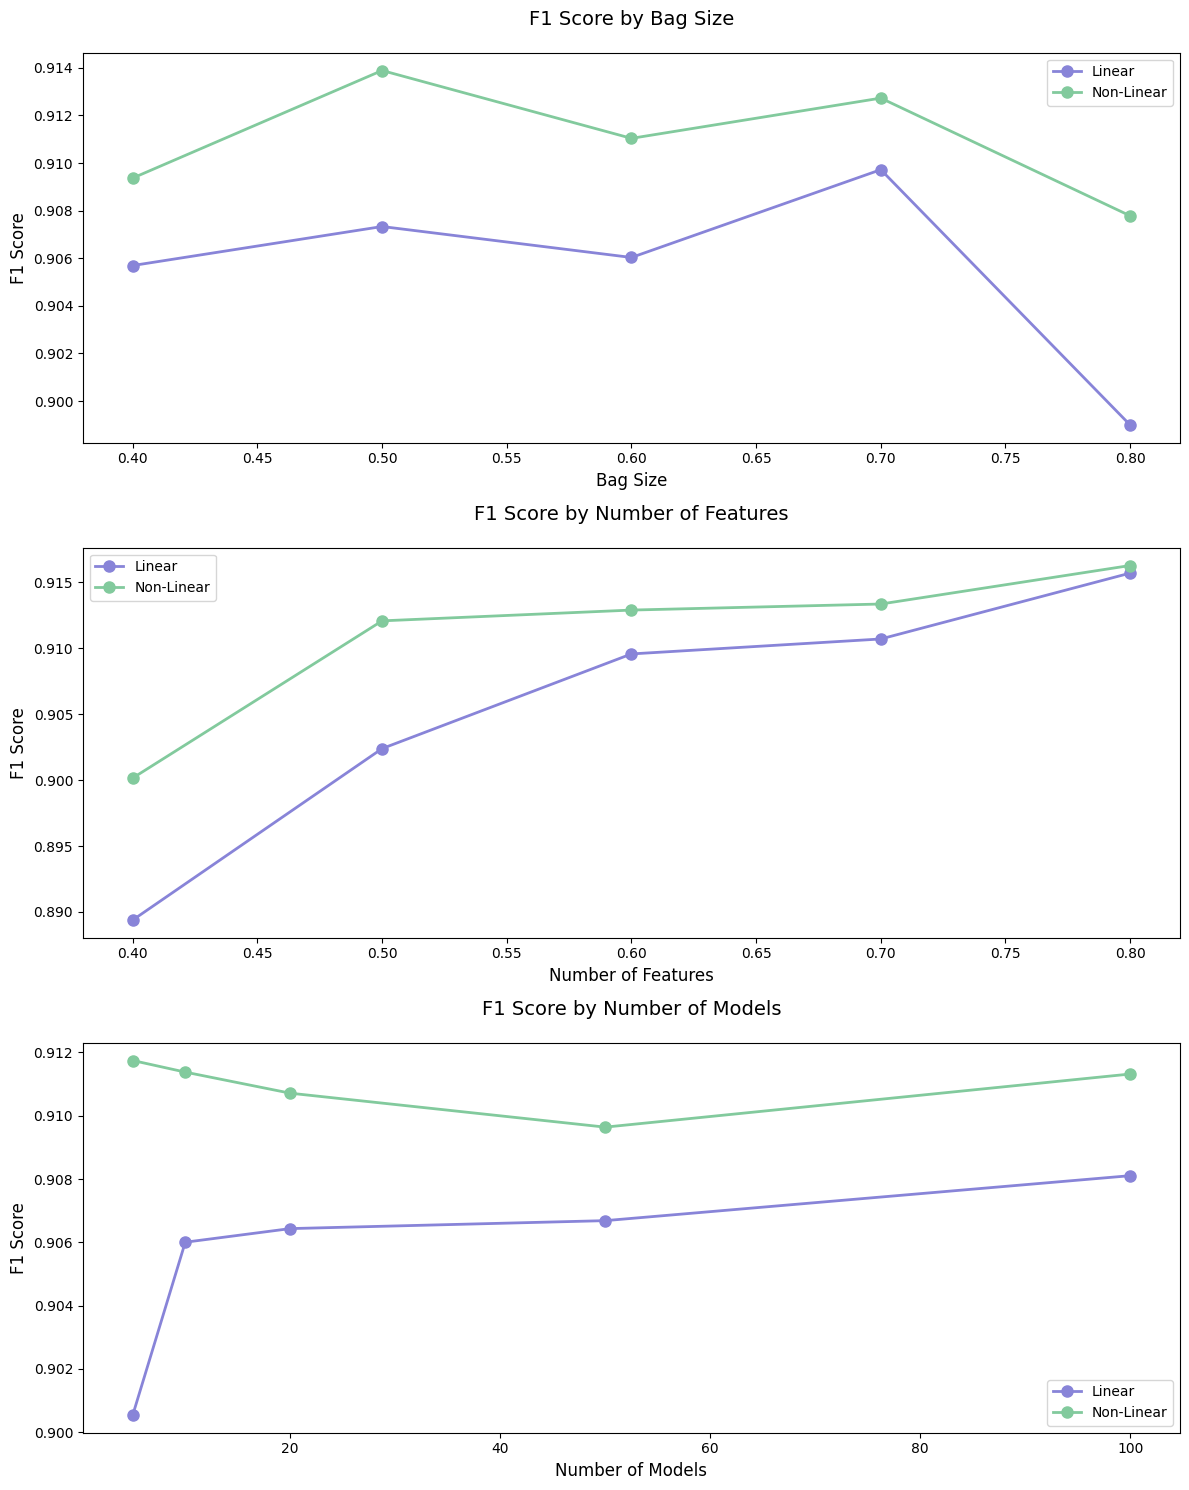


Summary Statistics:

Linear Dataset:
bag_size  num_features  num_models
0.4       0.4           5             0.8689
                        10            0.8931
                        20            0.8945
                        50            0.8972
                        100           0.9016
                                       ...  
0.8       0.8           5             0.9026
                        10            0.9087
                        20            0.9131
                        50            0.9137
                        100           0.9161
Name: f1_score, Length: 125, dtype: float64

Non-Linear Dataset:
bag_size  num_features  num_models
0.4       0.4           5             0.8759
                        10            0.9047
                        20            0.8990
                        50            0.9011
                        100           0.9066
                                       ...  
0.8       0.8           5             0.9128
                 

In [3]:
def create_comparison_plots(results, nl_results):
    # Create figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
    
    # Function to process data for each grouping
    def process_data(df, group_by):
        grouped = df.groupby(group_by)['f1_score'].mean().reset_index()
        # Ensure numeric types and sorting
        grouped[group_by] = pd.to_numeric(grouped[group_by])
        grouped['f1_score'] = pd.to_numeric(grouped['f1_score'])
        return grouped.sort_values(group_by)
    
    # Colors for consistency
    colors = ['#8884d8', '#82ca9d']
    
    # Plot 1: Bag Size Comparison
    data1 = process_data(results, 'bag_size')
    data2 = process_data(nl_results, 'bag_size')
    
    ax1.plot(data1['bag_size'], data1['f1_score'], '-o', color=colors[0], label='Linear', linewidth=2, markersize=8)
    ax1.plot(data2['bag_size'], data2['f1_score'], '-o', color=colors[1], label='Non-Linear', linewidth=2, markersize=8)
    ax1.set_title('F1 Score by Bag Size', fontsize=14, pad=20)
    ax1.set_xlabel('Bag Size', fontsize=12)
    ax1.set_ylabel('F1 Score', fontsize=12)
    ax1.legend(fontsize=10)
    # ax1.grid(True, linestyle='--', alpha=0.7)
    # ax1.set_ylim(0.7, 0.9)
    
    # Plot 2: Number of Features Comparison
    data1 = process_data(results, 'num_features')
    data2 = process_data(nl_results, 'num_features')
    
    ax2.plot(data1['num_features'], data1['f1_score'], '-o', color=colors[0], label='Linear', linewidth=2, markersize=8)
    ax2.plot(data2['num_features'], data2['f1_score'], '-o', color=colors[1], label='Non-Linear', linewidth=2, markersize=8)
    ax2.set_title('F1 Score by Number of Features', fontsize=14, pad=20)
    ax2.set_xlabel('Number of Features', fontsize=12)
    ax2.set_ylabel('F1 Score', fontsize=12)
    ax2.legend(fontsize=10)
    # ax2.grid(True, linestyle='--', alpha=0.7)
    # ax2.set_ylim(0.7, 0.9)
    
    # Plot 3: Number of Models Comparison
    data1 = process_data(results, 'num_models')
    data2 = process_data(nl_results, 'num_models')
    
    ax3.plot(data1['num_models'], data1['f1_score'], '-o', color=colors[0], label='Linear', linewidth=2, markersize=8)
    ax3.plot(data2['num_models'], data2['f1_score'], '-o', color=colors[1], label='Non-Linear', linewidth=2, markersize=8)
    ax3.set_title('F1 Score by Number of Models', fontsize=14, pad=20)
    ax3.set_xlabel('Number of Models', fontsize=12)
    ax3.set_ylabel('F1 Score', fontsize=12)
    ax3.legend(fontsize=10)
    # ax3.grid(True, linestyle='--', alpha=0.7)
    # ax3.set_ylim(0.7, 0.9)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print("\nLinear Dataset:")
    summary1 = results.groupby(['bag_size', 'num_features', 'num_models'])['f1_score'].mean().round(4)
    print(summary1)
    print("\nNon-Linear Dataset:")
    summary2 = nl_results.groupby(['bag_size', 'num_features', 'num_models'])['f1_score'].mean().round(4)
    print(summary2)

# Load your datasets
results = pd.read_csv('results/diabetes_linear_results.csv')
nl_results = pd.read_csv('results/diabetes_nonlinear_results.csv')

# Create the comparison plots
create_comparison_plots(results, nl_results)

In [4]:
import pandas as pd
import numpy as np
from scipy import stats
from typing import Tuple, Dict

def perform_statistical_analysis(linear_df: pd.DataFrame, 
                               nonlinear_df: pd.DataFrame) -> Dict:
    """
    Performs comprehensive statistical analysis comparing F1 scores between linear and nonlinear models.
    
    Parameters:
    -----------
    linear_df : pd.DataFrame
        DataFrame containing results from linear models
    nonlinear_df : pd.DataFrame
        DataFrame containing results from non-linear models
        
    Returns:
    --------
    Dict containing test results for different comparisons
    """
    results = {}
    
    # Overall comparison
    linear_scores = linear_df['f1_score']
    nonlinear_scores = nonlinear_df['f1_score']
    
    # 1. Shapiro-Wilk test for normality
    results['normality_test'] = {
        'linear': stats.shapiro(linear_scores),
        'nonlinear': stats.shapiro(nonlinear_scores)
    }
    
    # 2. Mann-Whitney U test (non-parametric)
    results['mann_whitney'] = stats.mannwhitneyu(
        linear_scores, 
        nonlinear_scores,
        alternative='two-sided'
    )
    
    # 3. Paired groupwise comparisons
    grouped_comparisons = {}
    
    # For each parameter (bag_size, num_features, num_models)
    for param in ['bag_size', 'num_features', 'num_models']:
        param_results = []
        
        # Group by the parameter and calculate mean F1 scores
        linear_grouped = linear_df.groupby(param)['f1_score'].mean()
        nonlinear_grouped = nonlinear_df.groupby(param)['f1_score'].mean()
        
        # Ensure we're comparing the same parameter values
        common_params = set(linear_grouped.index) & set(nonlinear_grouped.index)
        
        if len(common_params) > 1:  # Need at least 2 points for correlation
            linear_values = [linear_grouped[p] for p in common_params]
            nonlinear_values = [nonlinear_grouped[p] for p in common_params]
            
            # Paired t-test
            t_stat, p_value = stats.ttest_rel(linear_values, nonlinear_values)
            
            # Correlation test
            correlation, corr_p_value = stats.pearsonr(linear_values, nonlinear_values)
            
            param_results = {
                'paired_ttest': (t_stat, p_value),
                'correlation': (correlation, corr_p_value),
                'mean_difference': np.mean(linear_values) - np.mean(nonlinear_values),
                'std_difference': np.std(linear_values) - np.std(nonlinear_values)
            }
            
        grouped_comparisons[param] = param_results
    
    results['grouped_comparisons'] = grouped_comparisons
    
    return results

def print_analysis_results(results: Dict) -> None:
    """
    Prints the statistical analysis results in a readable format.
    
    Parameters:
    -----------
    results : Dict
        Dictionary containing the statistical test results
    """
    print("\nSTATISTICAL ANALYSIS RESULTS")
    print("=" * 50)
    
    # Normality Test Results
    print("\n1. Normality Tests (Shapiro-Wilk)")
    print("-" * 30)
    for model_type, (statistic, p_value) in results['normality_test'].items():
        print(f"{model_type.title()} models:")
        print(f"  Statistic: {statistic:.4f}")
        print(f"  p-value: {p_value:.4f}")
        print(f"  Normal distribution: {p_value > 0.05}\n")
    
    # Mann-Whitney U Test Results
    print("\n2. Mann-Whitney U Test (Overall Comparison)")
    print("-" * 30)
    mw_stat, mw_p = results['mann_whitney']
    print(f"Statistic: {mw_stat:.4f}")
    print(f"p-value: {mw_p:.4f}")
    print(f"Significant difference: {mw_p < 0.05}")
    
    # Grouped Comparisons
    print("\n3. Grouped Comparisons")
    print("-" * 30)
    for param, param_results in results['grouped_comparisons'].items():
        if param_results:  # If we have results for this parameter
            print(f"\n{param.replace('_', ' ').title()} Analysis:")
            
            t_stat, p_value = param_results['paired_ttest']
            print(f"Paired t-test:")
            print(f"  t-statistic: {t_stat:.4f}")
            print(f"  p-value: {p_value:.4f}")
            print(f"  Significant difference: {p_value < 0.05}")
            
            corr, corr_p = param_results['correlation']
            print(f"\nCorrelation:")
            print(f"  Correlation coefficient: {corr:.4f}")
            print(f"  p-value: {corr_p:.4f}")
            print(f"  Significant correlation: {corr_p < 0.05}")
            
            print(f"\nDifferences:")
            print(f"  Mean difference: {param_results['mean_difference']:.4f}")
            print(f"  Std difference: {param_results['std_difference']:.4f}")

# Example usage:
if __name__ == "__main__":
    # Assuming results and nl_results are your DataFrames
    statistical_results = perform_statistical_analysis(results, nl_results)
    print_analysis_results(statistical_results)


STATISTICAL ANALYSIS RESULTS

1. Normality Tests (Shapiro-Wilk)
------------------------------
Linear models:
  Statistic: 0.9075
  p-value: 0.0000
  Normal distribution: False

Nonlinear models:
  Statistic: 0.8487
  p-value: 0.0000
  Normal distribution: False


2. Mann-Whitney U Test (Overall Comparison)
------------------------------
Statistic: 161335.0000
p-value: 0.0000
Significant difference: True

3. Grouped Comparisons
------------------------------

Bag Size Analysis:
Paired t-test:
  t-statistic: -5.1929
  p-value: 0.0065
  Significant difference: True

Correlation:
  Correlation coefficient: 0.8434
  p-value: 0.0726
  Significant correlation: False

Differences:
  Mean difference: -0.0054
  Std difference: 0.0014

Num Features Analysis:
Paired t-test:
  t-statistic: -2.6625
  p-value: 0.0562
  Significant difference: False

Correlation:
  Correlation coefficient: 0.9622
  p-value: 0.0088
  Significant correlation: True

Differences:
  Mean difference: -0.0054
  Std differe

In [5]:
import pandas as pd
import numpy as np
from scipy import stats
from typing import Dict, List
import itertools

def analyze_single_dataframe(df: pd.DataFrame, group_columns: List[str]) -> Dict:
    """
    Performs comprehensive statistical analysis on groups within a single dataframe.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the results
    group_columns : List[str]
        List of columns to analyze (e.g., ['bag_size', 'num_features', 'num_models'])
        
    Returns:
    --------
    Dict containing test results for different comparisons
    """
    results = {}
    
    for column in group_columns:
        # Get unique values for the current parameter
        unique_values = sorted(df[column].unique())
        
        # Store results for this parameter
        param_results = {
            'kruskal_wallis': None,
            'pairwise_comparisons': [],
            'descriptive_stats': None,
            'effect_size': None
        }
        
        # 1. Kruskal-Wallis H-test (non-parametric ANOVA)
        groups = [df[df[column] == val]['f1_score'] for val in unique_values]
        h_stat, p_value = stats.kruskal(*groups)
        param_results['kruskal_wallis'] = {
            'statistic': h_stat,
            'p_value': p_value
        }
        
        # 2. Pairwise Mann-Whitney U tests with Bonferroni correction
        pairs = list(itertools.combinations(unique_values, 2))
        n_pairs = len(pairs)
        
        for val1, val2 in pairs:
            group1 = df[df[column] == val1]['f1_score']
            group2 = df[df[column] == val2]['f1_score']
            
            # Perform Mann-Whitney U test
            stat, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
            
            # Calculate effect size (r = Z / sqrt(N))
            n1, n2 = len(group1), len(group2)
            z_score = stats.norm.ppf(p_value / 2)  # Convert p-value to z-score
            effect_size = abs(z_score) / np.sqrt(n1 + n2)
            
            param_results['pairwise_comparisons'].append({
                'group1': val1,
                'group2': val2,
                'statistic': stat,
                'p_value': p_value,
                'p_value_adjusted': min(p_value * n_pairs, 1.0),  # Bonferroni correction
                'effect_size': effect_size
            })
        
        # 3. Descriptive statistics
        desc_stats = df.groupby(column)['f1_score'].agg([
            'count', 'mean', 'std', 'min', 'max'
        ]).round(4)
        param_results['descriptive_stats'] = desc_stats
        
        # Store results for this parameter
        results[column] = param_results
    
    return results

def print_single_df_analysis(results: Dict) -> None:
    """
    Prints the statistical analysis results in a readable format.
    
    Parameters:
    -----------
    results : Dict
        Dictionary containing the statistical test results
    """
    print("\nSINGLE DATAFRAME STATISTICAL ANALYSIS")
    print("=" * 50)
    
    for param, param_results in results.items():
        print(f"\nAnalysis for {param.replace('_', ' ').title()}")
        print("-" * 40)
        
        # 1. Print Kruskal-Wallis results
        kw = param_results['kruskal_wallis']
        print("\nKruskal-Wallis H-test:")
        print(f"H-statistic: {kw['statistic']:.4f}")
        print(f"p-value: {kw['p_value']:.4f}")
        print(f"Significant differences exist: {kw['p_value'] < 0.05}")
        
        # 2. Print descriptive statistics
        print("\nDescriptive Statistics:")
        print(param_results['descriptive_stats'])
        
        # 3. Print pairwise comparisons
        print("\nPairwise Comparisons (Mann-Whitney U with Bonferroni correction):")
        significant_pairs = []
        for comp in param_results['pairwise_comparisons']:
            if comp['p_value_adjusted'] < 0.05:
                significant_pairs.append(comp)
                print(f"\n{comp['group1']} vs {comp['group2']}:")
                print(f"  U-statistic: {comp['statistic']:.4f}")
                print(f"  p-value (adjusted): {comp['p_value_adjusted']:.4f}")
                print(f"  Effect size (r): {comp['effect_size']:.4f}")
                print(f"  Effect magnitude: {interpret_effect_size(comp['effect_size'])}")
        
        if not significant_pairs:
            print("No significant pairwise differences found.")

def interpret_effect_size(r: float) -> str:
    """
    Interprets the effect size based on Cohen's guidelines.
    """
    if r < 0.1:
        return "Negligible effect"
    elif r < 0.3:
        return "Small effect"
    elif r < 0.5:
        return "Medium effect"
    else:
        return "Large effect"

# Example usage
if __name__ == "__main__":
    # Analyze either the linear or non-linear results
    group_columns = ['bag_size', 'num_features', 'num_models']
    
    print("\nAnalysis for Linear Models:")
    linear_results = analyze_single_dataframe(results, group_columns)
    print_single_df_analysis(linear_results)
    
    print("\nAnalysis for Non-Linear Models:")
    nonlinear_results = analyze_single_dataframe(nl_results, group_columns)
    print_single_df_analysis(nonlinear_results)


Analysis for Linear Models:

SINGLE DATAFRAME STATISTICAL ANALYSIS

Analysis for Bag Size
----------------------------------------

Kruskal-Wallis H-test:
H-statistic: 15.8820
p-value: 0.0032
Significant differences exist: True

Descriptive Statistics:
          count    mean     std     min     max
bag_size                                       
0.4         125  0.9057  0.0225  0.8578  0.9405
0.5         125  0.9073  0.0207  0.8605  0.9347
0.6         125  0.9060  0.0237  0.8421  0.9405
0.7         125  0.9097  0.0205  0.8651  0.9405
0.8         125  0.8990  0.0246  0.8296  0.9325

Pairwise Comparisons (Mann-Whitney U with Bonferroni correction):

0.5 vs 0.8:
  U-statistic: 9450.5000
  p-value (adjusted): 0.0418
  Effect size (r): 0.1812
  Effect magnitude: Small effect

0.7 vs 0.8:
  U-statistic: 9986.0000
  p-value (adjusted): 0.0014
  Effect size (r): 0.2404
  Effect magnitude: Small effect

Analysis for Num Features
----------------------------------------

Kruskal-Wallis H-test: